# End to End Object Detection with Vision Transformers in ART

Demo for applying the DEtection TRansformer (DETR) estimator in ART for object detection and attacking the ViT using the Robust DPatch method.

### Define imports, constants and helper functions

In [1]:
from art.estimators.object_detection.pytorch_detr import PyTorchDetectionTransformer
import imagenet_stubs
from torchvision.transforms import transforms
import PIL.Image
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import requests
import pandas as pd


COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def extract_predictions(predictions_, conf_thresh):
    predictions_class = [COCO_CLASSES[i] for i in list(predictions_["labels"])]
    if len(predictions_class) < 1:
        return [], [], []
        
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]
    predictions_score = list(predictions_["scores"])

    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t
    else:
        return [], [], []
        
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores

def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)
    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
        transforms.Resize(800, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(800),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN,
                                 std=STD),
    ])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


### Load small set of ImageNet images, resize, crop and normalize 

In [2]:
in_images = []
for image_path in imagenet_stubs.get_image_paths()[:7]:
    im = PIL.Image.open(image_path).convert('RGB')
    im = transform(im).numpy()
    in_images.append(im)
in_images = np.array(in_images)

### Load a COCO image, resize, crop and normalize

In [3]:
urls = ['http://images.cocodataset.org/val2017/000000039769.jpg',
'http://images.cocodataset.org/val2017/000000397133.jpg',
'http://images.cocodataset.org/val2017/000000037777.jpg',
'http://images.cocodataset.org/val2017/000000454661.jpg',
'http://images.cocodataset.org/val2017/000000094852.jpg']
coco_images = []
for url in urls:
    im = PIL.Image.open(requests.get(url, stream=True).raw)
    im = transform(im).numpy()
    coco_images.append(im)
coco_images = np.array(coco_images)

### Create the detector

In [4]:
detector = PyTorchDetectionTransformer(channels_first=True)

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main
/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/kieranfraser/git/personal/art/env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Test detector on ImageNet images

/Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


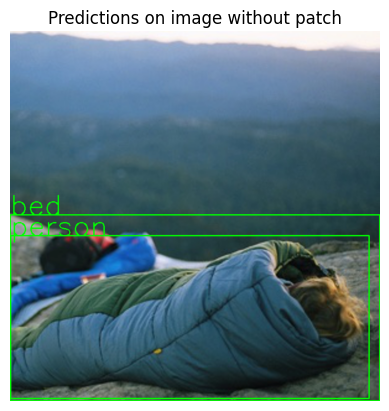

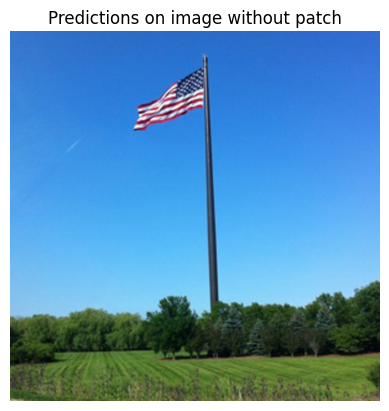

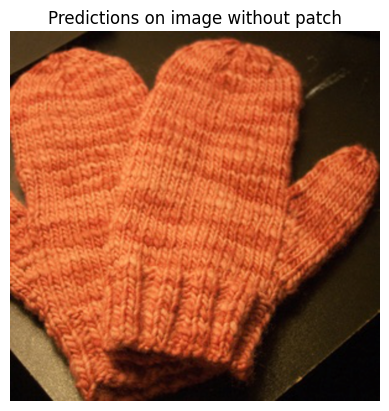

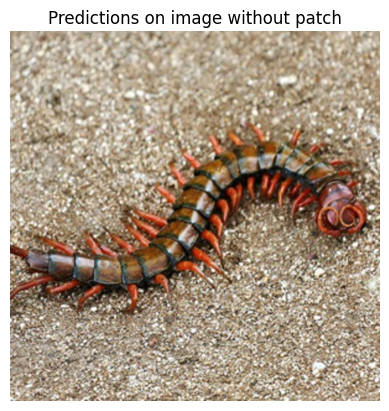

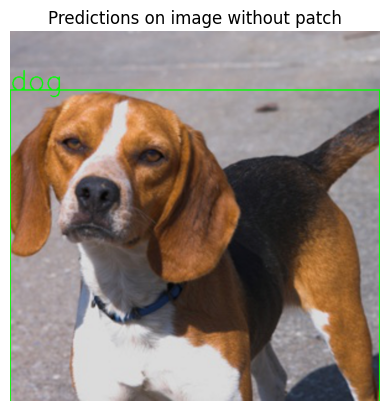

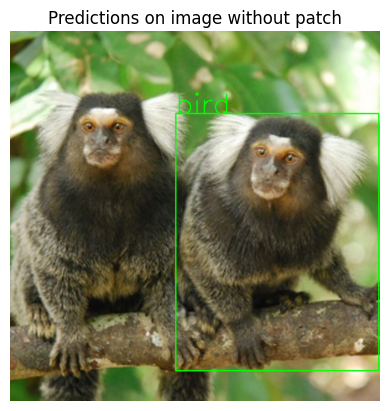

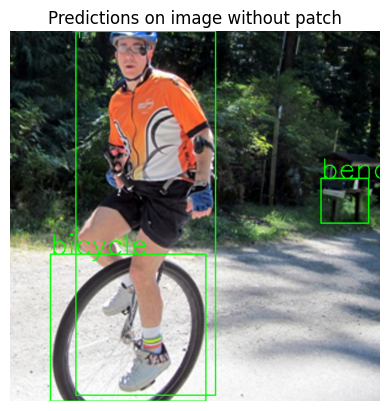

In [5]:
results = detector.predict(in_images)
for i in range(len(results)):
    preds = extract_predictions(results[i], 0.8)
    im = (invTrans(torch.from_numpy(in_images))[i].numpy().transpose(1,2,0)*255).astype(np.uint8)
    plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title="Predictions on image without patch")

### Test detector on COCO images

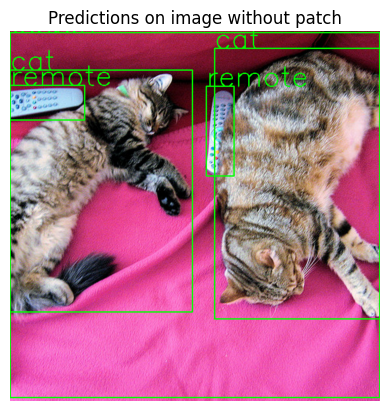

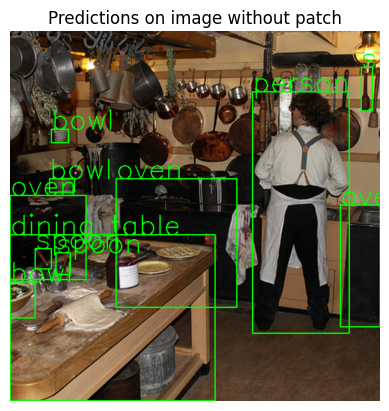

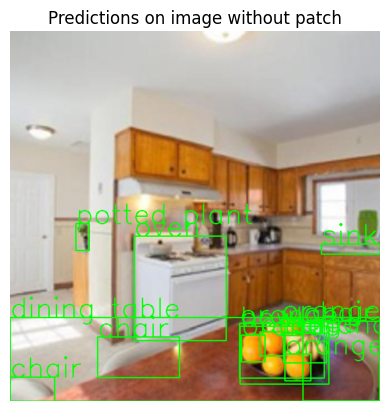

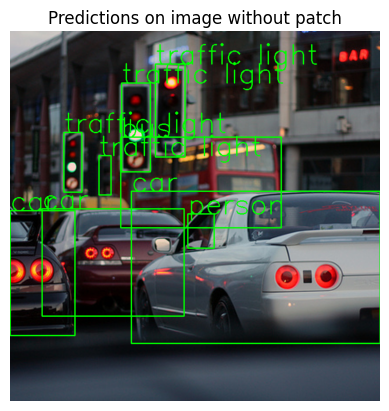

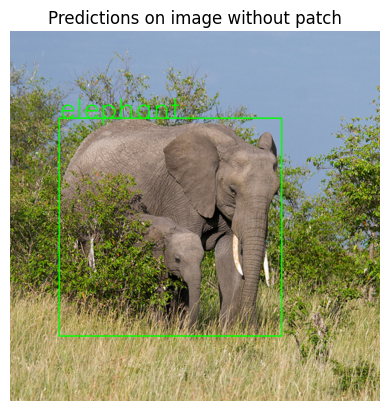

In [6]:
results = detector.predict(coco_images)
for i in range(len(results)):
    preds = extract_predictions(results[i], 0.8)
    im = (invTrans(torch.from_numpy(coco_images))[i].numpy().transpose(1,2,0)*255).astype(np.uint8)
    plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title="Predictions on image without patch")

### Run an Adversarial Attack
- RobustDPatch
- COCO image

/Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
100%|██████████| 50/50 [01:49<00:00,  2.20s/it]


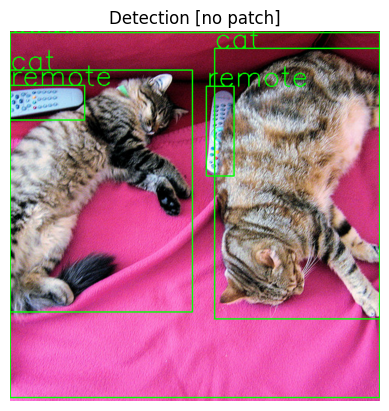

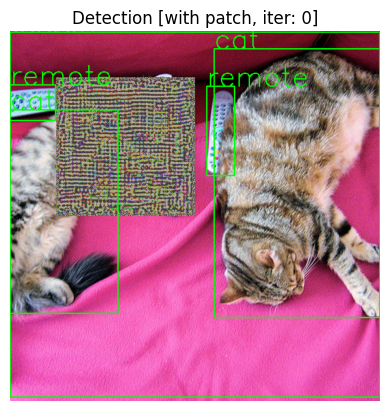

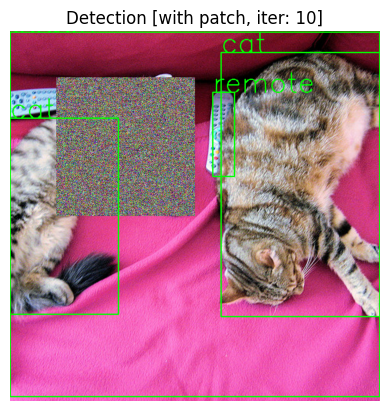

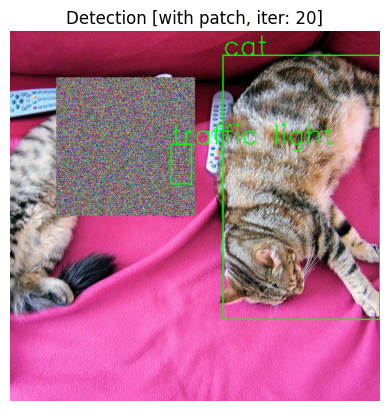

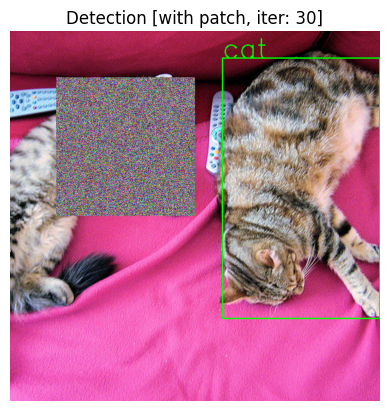

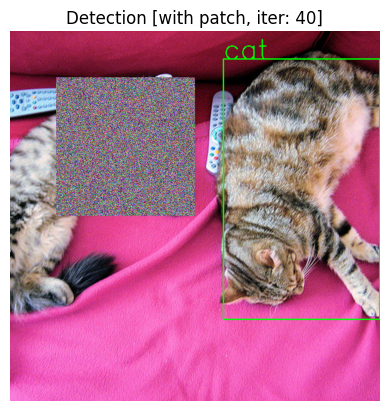

In [9]:
from art.attacks.evasion import RobustDPatch
from tqdm import tqdm

x = coco_images[[0]].copy()
y = detector.predict(x)

preds = extract_predictions(y[0], 0.8)
im = (invTrans(torch.from_numpy(x))[0].numpy().transpose(1,2,0)*255).astype(np.uint8)
plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title="Detection [no patch]")

attack = RobustDPatch(
            detector,
            patch_shape=(3,300,300),
            patch_location=(100, 100),
            crop_range=(0, 0),
            brightness_range=(1.0, 1.0),
            rotation_weights=(1, 0, 0, 0),
            sample_size=1,
            learning_rate=1.0,
            max_iter=1,
            batch_size=1,
            verbose=False,
        )

loss_history = []
for i in tqdm(range(50)):
    patch = attack.generate(x)
    x_patch = attack.apply_patch(x)

    detector._model.train()
    loss_components, _, _ = detector._get_losses(x_patch, y)
    losses = {}
    for loss in loss_components.keys():
        if 'loss' in loss:
            losses[loss] = loss_components[loss].item()
    loss_history.append(losses)

    if i%20==0:
        _y = detector.predict(x_patch)
        preds = extract_predictions(_y[0], 0.8)
        im = (invTrans(torch.from_numpy(x_patch))[0].numpy().transpose(1,2,0)*255).astype(np.uint8)
        plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, iter: {i}]")

_y = detector.predict(x_patch)
preds = extract_predictions(_y[0], 0.8)
im = (invTrans(torch.from_numpy(x_patch))[0].numpy().transpose(1,2,0)*255).astype(np.uint8)
plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, final]")  

### Plots of detection losses per epoch

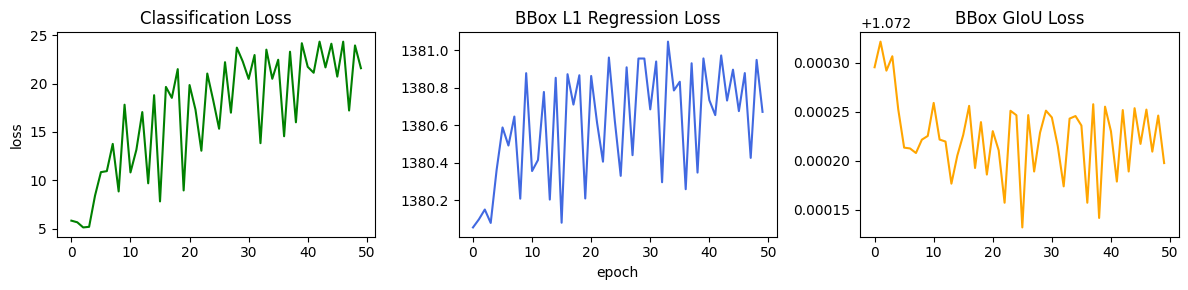

In [53]:
losses = pd.DataFrame(loss_history)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
losses.loss_ce.plot(ylabel='loss', ax = axes[0], subplots=True, color='g')
losses.loss_bbox.plot(xlabel='epoch', ax = axes[1],subplots=True, color='royalblue')
losses.loss_giou.plot( ax = axes[2],subplots=True, color='orange')


axes[0].set_title('Classification Loss')
axes[1].set_title('BBox L1 Regression Loss')
axes[2].set_title('BBox GIoU Loss')
fig.tight_layout()

### Run the attack on ImageNet image

100%|██████████| 200/200 [07:14<00:00,  2.17s/it]


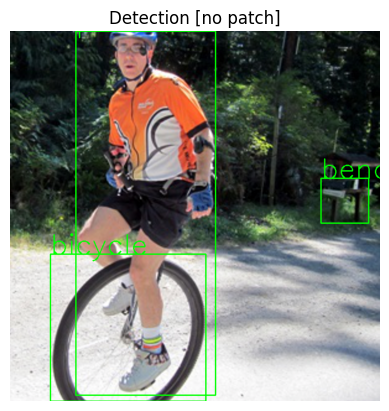

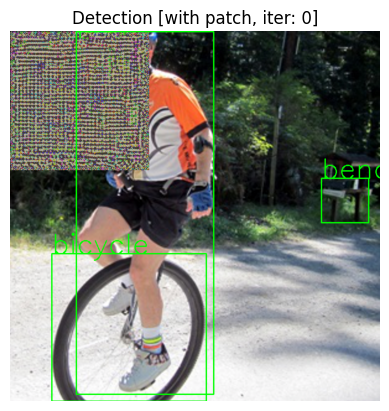

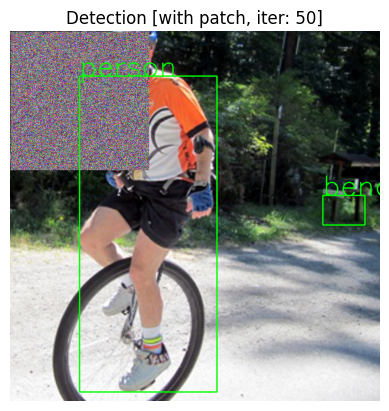

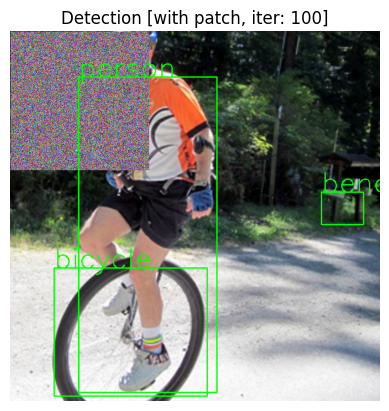

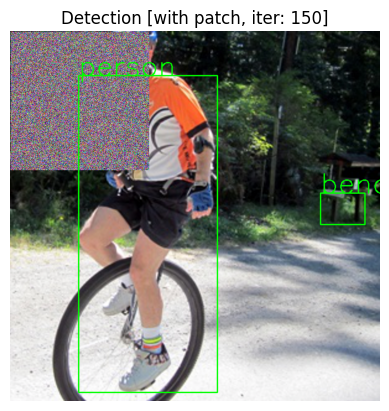

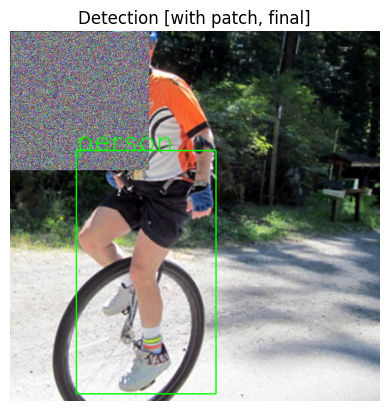

In [67]:
from art.attacks.evasion import RobustDPatch
from tqdm import tqdm

x = in_images[[6]].copy()
y = detector.predict(x)

preds = extract_predictions(y[0], 0.8)
im = (invTrans(torch.from_numpy(x))[0].numpy().transpose(1,2,0)*255).astype(np.uint8)
plot_image_with_boxes(img=im.copy(), boxes=preds[1], pred_cls=preds[0], title="Detection [no patch]")

attack = RobustDPatch(
            detector,
            patch_shape=(3,300,300),
            patch_location=(1, 1),
            crop_range=(0, 0),
            brightness_range=(1.0, 1.0),
            rotation_weights=(1, 0, 0, 0),
            sample_size=1,
            learning_rate=1.0,
            max_iter=1,
            batch_size=1,
            verbose=False,
        )

loss_history = []
for i in tqdm(range(200)):
    patch = attack.generate(x)
    x_patch = attack.apply_patch(x)

    detector._model.train()
    loss_components, _, _ = detector._get_losses(x_patch, y)
    losses = {}
    for loss in loss_components.keys():
        if 'loss' in loss:
            losses[loss] = loss_components[loss].item()
    loss_history.append(losses)

    if i%50==0:
        _y = detector.predict(x_patch)
        preds = extract_predictions(_y[0], 0.8)
        im = (invTrans(torch.from_numpy(x_patch))[0].numpy().transpose(1,2,0)*255).astype(np.uint8)
        plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, iter: {i}]")

_y = detector.predict(x_patch)
preds = extract_predictions(_y[0], 0.8)
im = (invTrans(torch.from_numpy(x_patch))[0].numpy().transpose(1,2,0)*255).astype(np.uint8)
plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, final]")  

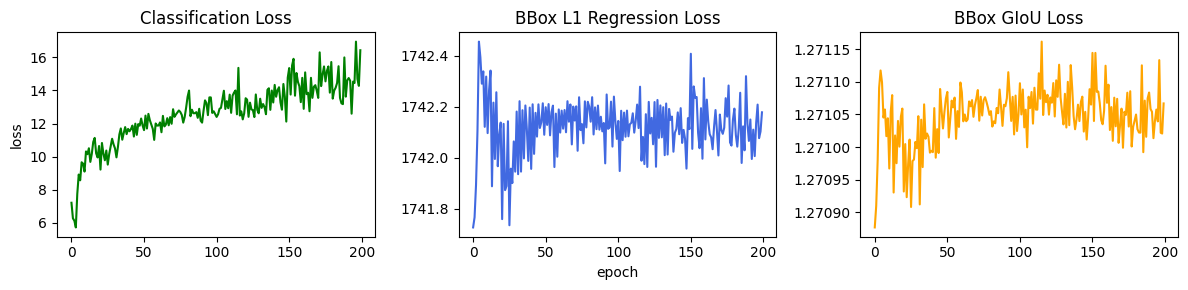

In [68]:
losses = pd.DataFrame(loss_history)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
losses.loss_ce.plot(ylabel='loss', ax = axes[0], subplots=True, color='g')
losses.loss_bbox.plot(xlabel='epoch', ax = axes[1],subplots=True, color='royalblue')
losses.loss_giou.plot( ax = axes[2],subplots=True, color='orange')


axes[0].set_title('Classification Loss')
axes[1].set_title('BBox L1 Regression Loss')
axes[2].set_title('BBox GIoU Loss')
fig.tight_layout()